# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** Claire Meyer, Nicolas Furrer, Philipp Schuler
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [ ]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
# tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
# with tarfile.open(tar_path, mode='r:gz') as tar:
#    tar.extractall(path=data_base_path)

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [ ]:
import scipy.io
import numpy as np
from sympy.solvers import solve
from sympy import symbols
import matplotlib.pyplot as plt
%matplotlib inline


data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

*Add your implementation and discussion*

In [ ]:
# Compute the covariance matrix sigma
# Parameter : Data (200x2)(number mesure x dimension), mean of the data (1x2)(1 x dimension)
# Return : Covariance matrix sigma (2x2)(dimension x dimension)
def covariance(data, mean_value):
    X = data-mean_value
    M = data.shape[0]
    sigma = 1/M*(X.T @ X)
    return sigma

def pdf(data, data_mu, data_sigma):
    p = np.empty((data.shape[0],1))
    for i in range(data.shape[0]):
        X = data[:][i]-data_mu
        sigma_inv = np.linalg.inv(data_sigma)
        sigma_det = np.linalg.det(data_sigma)
        exp_part = -1/2*(X @ sigma_inv @ X.T)
        p[i] = 1/(2*np.pi*np.sqrt(sigma_det))*np.exp(exp_part)
    return p

def discriminantFonction(data_point, data, Pw):
    data_mu = np.mean(data, axis = 0)
    data_sigma = covariance(data, data_mu)
    data_pdf = pdf(data_point, data_mu, data_sigma)
    g = np.log(data_pdf*Pw)
    return g

def bayesClassification(data_point, class_a, class_b, class_c, Pw):
    dist = np.zeros(3)
    dist[0] = discriminantFonction(data_point, class_a, Pw)
    dist[1] = discriminantFonction(data_point, class_b, Pw)
    dist[2] = discriminantFonction(data_point, class_c, Pw)
    
    return chr(np.argmax(dist)+97) # to get a, b or c class

point1 = np.array([[-10,-2]])

Pw = 1/3
print(bayesClassification(point1,a,b,c,Pw))

In [ ]:
# Compute different parameter : mean, sigma inverse and parameter c for equation page 12 Cours 5
# Parameter : Data (200x2)(number mesure x dimension)
# Return : mean (1x2)(1 x dimension, inverse matrix sigma (2x2)(dimension x dimension), parameter c (1x1)
def computation(data):
    mean = np.mean(data, axis = 0)
    sigma = covariance(data, mean)
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    c = np.log(2*np.pi*np.sqrt(sigma_det))
    return mean, sigma_inv, c

# Find the decision curves between two data set
# Parameter : 2 Data (200x2)(number mesure x dimension)
# Return : equation of decision curves (2 equation)
def decision_curve(data_i, data_j):
    
    mean_i, sigma_i_inv, c_i = computation(data_i) 
    mean_j, sigma_j_inv, c_j = computation(data_j) 
    
    x, y = symbols('x, y', integer=True)
    X = np.array([[x,y]])
    
    g_i = -1/2*((X-mean_i)@sigma_i_inv@(X-mean_i).T)+np.log(1/3)-c_i
    g_j = -1/2*((X-mean_j)@sigma_j_inv@(X-mean_j).T)+np.log(1/3)-c_j
    g = g_i-g_j
    
    equ = solve(g[0][0],y)
    return equ

# Evaluate a equation with the a vector of value x0
# Parameter : 1 equation with x as a parameter, vector of value to evaluate the equation
# Return : vector of value of y
def evaluate_y(equation, x0):
    x = symbols('x', integer=True)
    y = np.empty(x0.shape[0])
    for i in range(x0.shape[0]):
        y[i] = equation.subs(x, x0[i])
    return y
        

# Computation of the decision_curve
equ1 = decision_curve(a,b)
equ2 = decision_curve(b,c)
equ3 = decision_curve(c,a)

# Computation of y for graph
x1 = np.arange(start=-14, stop=14,step=0.01)
x2 = np.arange(start=-7.03, stop = 14, step=0.01)
x3 = np.arange(start=-7.64, stop = 14, step=0.01)
y11 = evaluate_y(equ1[0],x1)
y12 = evaluate_y(equ1[1],x1)
y21 = evaluate_y(equ2[0],x2)
y22 = evaluate_y(equ2[1],x2)
y31 = evaluate_y(equ3[0],x3)
y32 = evaluate_y(equ3[1],x3)

# Plot
for i in range(a.shape[0]):
    plt.plot(a[i][0],a[i][1],'ro')
    plt.plot(b[i][0],b[i][1],'bo')
    plt.plot(c[i][0],c[i][1],'go')
plt.plot(x1,y11,'c')
plt.plot(x1,y12,'c')
plt.plot(x2,y21,'m')
plt.plot(x2,y22,'m')
plt.plot(x3,y31,'k')
plt.plot(x3,y32,'k')
plt.show()


### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

*Add your implementation and discussion*

The Mahalanobis distance is defined by :

$d_m = \left( \left( x-\mu_i \right) \Sigma^{-1}_{i} \left( x-\mu_i \right) \right)$

Where :
- $x$ is the point to be classified
- $\mu_i$ is the mean of the $i$-th distribution
- $\Sigma_i$ is the covariance matrix of the $i$-th distribution

The Mahalanobis distance is a measure of the distance between a point P and a distribution D, introduced by P. C. Mahalanobis in 1936. It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis. If each of these axes is re-scaled to have unit variance, then the Mahalanobis distance corresponds to standard Euclidean distance in the transformed space. The Mahalanobis distance is thus unitless and scale-invariant, and takes into account the correlations of the data set. 


In [ ]:
def mahalanobisDistance(point, data):
    mean_value = np.mean(data, axis = 0)
    sigma_value = covariance(data, mean_value)
    return np.sqrt((point-mean_value)@np.linalg.inv(sigma_value)@(point-mean_value).T)

def mahalanobisClassification(point, class_a, class_b, class_c):
    dist = np.zeros(3)
    dist[0] = mahalanobisDistance(point, class_a)
    dist[1] = mahalanobisDistance(point, class_b)
    dist[2] = mahalanobisDistance(point, class_c)
    
    return chr(np.argmin(dist)+97) # to get a, b or c class

In [ ]:
import matplotlib.pyplot as plt

point = np.zeros((1,2))
point[0][0] = -10
point[0][1] = 0

print(mahalanobisClassification(point,a,b,c))

# Plot images
n_lin = 1
n_col = 1
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))
ax.plot(a[:,0],a[:,1],".")
ax.plot(b[:,0],b[:,1],".")
ax.plot(c[:,0],c[:,1],".")
ax.set_title("Classes A, B and C 2D representation")
ax.legend(("Class a","Class b","Class c"))

# End of cell
print("Done")

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP
*Add your implementation and discussion*

#### Model training

SciKit proposes a multi-layer perceptron classifier function 'MLPClassifier'. 
This classifier proposes different architectures and activation functions. 
We tested all of them to then decide the best classifier for our use case:

 
 | Solver | Loss   | Training score | Test score | Beta 2 |
 |--------|--------|----------------|------------|--------|
 | Adam   | 0.03   |  0.9915        | 0.9581     | 0.9999 |
 | Adam   | 0.03   |  0.9848        | 0.9624     | 0.999  |
 | SGD    | 0.23   |  0.9246        | 0.9171     | N/A    |
 | LBFGS  | 120.51 |  0.1169        | 0.1075     | N/A    |
 
LBFGD is not optimised for large training sets and this is shown by the tests, as it output random values of loss and score at each iteration. 

SGD or stochastic gradient descent, is working but takes much more steps to converge than Adam. 
As adam has the best results without optimisation, and SGD seems to not converging very quickly (200 epochs and not converged) we will use Adam for the nexts steps and try to optimise this one
 
Adam with different activation functions:
* Relu: 3.3%
* tanh: 5.2%

Adam with different alpha values and relu:
* 0.0001: 3.3%
* 0.001 : 3.9%
 
Adam with different beta_2 values:
* 0.999 : 3.3%
* 0.9999: 3.4%

The changes of parameters are worsening the test errors.

In [84]:
from sklearn.neural_network import MLPClassifier

# flattening training and testing set
flattened_training_set = train_images.reshape(train_set_size, image_shape[0]*image_shape[1])

flattened_testing_set = test_images.reshape(test_set_size,image_shape[0]*image_shape[1])

def classifier_compare_plot():
    #definition of the used models
    model_lbfgs = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100), max_iter=200, random_state=1)

    model_adam_1 = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
                    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=1, 
                    tol=0.0001, verbose=False, warm_start=False, early_stopping=True, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.99999, epsilon=1e-08, n_iter_no_change=10)

    model_sgd = MLPClassifier(solver='sgd', alpha=1e-4, hidden_layer_sizes=(100), max_iter=100, random_state=1, learning_rate='adaptive')


    model_lbfgs.fit(flattened_training_set, train_labels)
    model_adam_1.fit(flattened_training_set, train_labels)
    model_sgd.fit(flattened_training_set, train_labels)
    
    return model_lbfgs, model_sgd, model_adam_1

    


In [82]:
def test_score(model):
    output = model.predict(flattened_testing_set)
    nb_wrong = 0
    idx_list = []
    for idx, predicted in enumerate(output):
        if predicted != test_labels[idx]:
            nb_wrong = nb_wrong +1 
            idx_list.append(idx)

    return 1-(nb_wrong/test_set_size)

Adam: 	loss =   0.012,	 training score = 0.9954, test score = 0.966
SGD: 	loss =   0.182,	 training score = 0.9474, test score = 0.927
LBFGS: 	loss = 120.509,	 training score = 0.1169, test score = 0.108


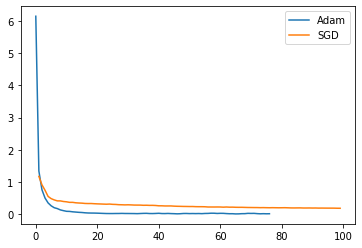

In [83]:
#model_lbfgs, model_sgd, model_adam_1 = classifier_compare_plot()

test_score_lbfgs = test_score(model_lbfgs)
test_score_adam_1 = test_score(model_adam_1)
test_score_sgd = test_score(model_sgd)


print("Adam: \tloss =   " + str(round(model_adam_1.loss_, 3)) + ",\t training score = " + str(round(model_adam_1.score(flattened_training_set, train_labels),4)) + ",\t test score = " + str(round(test_score_adam_1,3)) + 
          "\nSGD: \tloss =   " + str(round(model_sgd.loss_,3)) + ",\t training score = " + str(round(model_sgd.score(flattened_training_set, train_labels),4)) + ",\t test score = " + str(round(test_score_sgd, 3)) + 
          "\nLBFGS: \tloss = " + str(round(model_lbfgs.loss_, 3)) + ",\t training score = " + str(round(model_lbfgs.score(flattened_training_set, train_labels),4)) + ",\t test score = " + str(round(test_score_lbfgs,3)) )

plt.plot(model_adam_1.loss_curve_)
plt.plot(model_sgd.loss_curve_)
plt.legend(["Adam", "SGD"])